In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import yaml

In [16]:
users_df = pd.read_csv('DATA2/users.csv')
# print(users_df.head())
# print(users_df.info())

orders_df = pd.read_parquet('DATA2/orders.parquet', engine='fastparquet')
# print(orders_df.head(20))
# print(orders_df.info())

with open('DATA2/books.yaml', 'r', encoding='utf-8') as file:
    books_data = yaml.safe_load(file)

books_df = pd.DataFrame(books_data)

In [17]:
def clean_price(price_str):
    if pd.isna(price_str):
        return None

    price_str = str(price_str).strip()

    is_euro = ('€' in price_str) or ('EUR' in price_str)

    price_str = price_str.replace('$', '').replace('€', '').replace('USD', '').replace('EUR', '').replace('¢', '.')
    price_str = price_str.strip()
    
    try:
        price = float(price_str)
    except:
        return None

    if is_euro:
        price = price * 1.2
    
    return price

# test_prices = ['27.00$', '€50¢50', 'USD 45.99', '€ 71.00','63.5EUR ', '52.25 $']
# for p in test_prices:
#     print(f"{p} -> {clean_price(p)}")


In [18]:
import re

def clean_timestamp(timestamp_str):
    if pd.isna(timestamp_str):
        return None
    
    timestamp_str = str(timestamp_str).strip()

    timestamp_str = timestamp_str.replace(';', ' ').replace(',', ' ')
    timestamp_str = timestamp_str.replace('A.M.', 'AM').replace('P.M.', 'PM')
    
    iso_pattern = r'\d{4}-\d{2}-\d{2}'

    if re.search(iso_pattern, timestamp_str):
        result = pd.to_datetime(timestamp_str, errors='coerce', dayfirst=False) #ISO
    else:
        result = pd.to_datetime(timestamp_str, errors='coerce', dayfirst=True)
    return result

# test_timestamps = [
#     '10/01/24 10:38:08 A.M.',
#     '10:14;19-Oct-2024',
#     '22:13:35,2025-07-02',
#     '2025-10-20 16:25:20',
#     '08:48:47 A.M.,28-August-2024',
#     '00:52:59, 2024-07-01',
#     '22:10:29 02/07/25',
#     '30-Oct-2024, 15:56',
#     '01:34:17 P.M. 11-November-2024',
#     '15-Jul-2024,01:16:06 A.M.',
#     '16:02:39, 2024-12-23',
#     '03:37,  2-Apr-2025',
#     '12:18:07,05/17/24',
#     '07:22, 04/25/24',
#     '2025-01-20 21:14',
#     '19:46, 10/03/24',
#     '12:23:47 A.M.;23-September-2024',
#     '11/01/24 01:56:57 pm',
#     '3-OCT-2024, 03:34',
#     '2024-08-09T16:02:42.627'
# ]

# for ts in test_timestamps:
#     print(f"{ts} -> {clean_timestamp(ts)}")

In [19]:
orders_df['clean_price'] = orders_df['unit_price'].apply(clean_price)
orders_df['clean_timestamp'] = orders_df['timestamp'].apply(clean_timestamp)

# print(orders_df[['unit_price', 'clean_price', 'timestamp', 'clean_timestamp']].head(10))

# print(f"\nprice fail: {orders_df['clean_price'].isna().sum()}")
# print(f"timestamp fail: {orders_df['clean_timestamp'].isna().sum()}")

C:\Users\hp\AppData\Local\Temp\ipykernel_23644\4048238529.py:15: UserWarning: Parsing dates in %d:%M %Y-%m-%H format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  result = pd.to_datetime(timestamp_str, errors='coerce', dayfirst=False) #ISO
C:\Users\hp\AppData\Local\Temp\ipykernel_23644\4048238529.py:15: UserWarning: Parsing dates in %d:%M:%S %p %Y-%m-%I format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  result = pd.to_datetime(timestamp_str, errors='coerce', dayfirst=False) #ISO
C:\Users\hp\AppData\Local\Temp\ipykernel_23644\4048238529.py:15: UserWarning: Parsing dates in %H:%d  %Y-%m-%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  result = pd.to_datetime(timestamp_str, errors='coerce', dayfirst=False) #ISO
C:\Users\hp\AppData\Local\Temp\ipykernel_23644\4048238529.py

In [20]:
# print(f"rows before cleaning: {len(orders_df)}")
orders_df = orders_df.dropna(subset=['clean_price', 'clean_timestamp'])
# print(f"rows after cleaning: {len(orders_df)}")

# paid_price = quantity * clean_price
orders_df['paid_price'] = orders_df['quantity'] * orders_df['clean_price']
# print(orders_df[['quantity', 'clean_price', 'paid_price']].head())

orders_df['date'] = orders_df['clean_timestamp'].dt.date
# print(orders_df[['clean_timestamp', 'date']].head())

duplicates = orders_df.duplicated(subset=['id'])
# print(f"duplicated orders: {duplicates.sum()} ")
if duplicates.sum() > 0:
    orders_df = orders_df.drop_duplicates(subset=['id'])

In [21]:
#Compute daily revenue (sum of paid_price grouped by date) and find top 5 days by revenue
daily_revenue_top5 = orders_df.groupby('date')['paid_price'].sum().sort_values(ascending=False).head(5)

print(f"top 5 days:{daily_revenue_top5}")

top 5 days:date
2024-12-24    42137.010
2024-08-29    40556.078
2024-12-29    39297.212
2025-01-30    39021.688
2024-11-29    35207.050
Name: paid_price, dtype: float64


In [22]:
#Find how many real unique users there are. Note that user can change address or change phone or even provide alias instead of a real name; 
# you need to reconciliate data. You may assume that only one field is changed.

# print("users_df is null：")
# print(users_df.isnull().sum())

class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))  
    
    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])  
        return self.parent[x]
    
    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        if root_x != root_y:
            self.parent[root_x] = root_y
    
    def count_groups(self):
        return len(set(self.find(i) for i in range(len(self.parent))))
    
    def get_group_members(self, x):
        root = self.find(x)
        return [i for i in range(len(self.parent)) if self.find(i) == root]

n_users = len(users_df)  
uf = UnionFind(n_users)

users_clean = users_df.copy()

na_mask = users_clean['address'].isna()
na_count = na_mask.sum()
users_clean.loc[na_mask, 'address'] = [f'MISSING_ADDRESS_{i}' for i in range(na_count)]

for field in ['email', 'phone', 'name', 'address']:
    groups = users_clean.groupby(field).groups  
    for indices in groups.values():
        if len(indices) > 1:
            first = indices[0]
            for idx in indices[1:]:
                uf.union(first, idx)

unique_users = uf.count_groups()
print(f"real unique users: {unique_users}")

real unique users: 2633


In [23]:
# Find how how many unique sets of authors there are. For example, if John and Paul wrote a book together 
# and wrote several books separately, it means that there are 3 different sets.

# print(f"books number: {len(books_df)}")

author_sets = set()

for author_str in books_df[':author']:
    if pd.isna(author_str):
        continue
    
    authors = [a.strip() for a in str(author_str).split(',')]
    
    author_tuple = tuple(sorted(authors))
    
    author_sets.add(author_tuple)

unique_author_sets = len(author_sets)
print(f"unique sets of authors: {unique_author_sets}")

unique sets of authors: 293


In [24]:
# Find the most popular (by sold book count) author (or author set).
book_sales = orders_df.groupby('book_id')['quantity'].sum()
# print(book_sales)

books_with_sales = books_df.merge(
    book_sales, 
    left_on=':id',     
    right_index=True,   
    how='left'
)

books_with_sales['quantity'] = books_with_sales['quantity'].fillna(0)

def standardize_author(author_str):
    if pd.isna(author_str):
        return ()
    authors = [a.strip() for a in str(author_str).split(',')]
    return tuple(sorted(authors))

books_with_sales['author_set'] = books_with_sales[':author'].apply(standardize_author)

author_sales = books_with_sales.groupby('author_set')['quantity'].sum().sort_values(ascending=False)

most_popular = author_sales.idxmax()
max_sales = author_sales.max()

if len(most_popular) == 1:
    author_name = most_popular[0]
else:
    author_name = ' & '.join(most_popular)

print(f"most popular set: {author_name}")
print(f"count: {max_sales} ")


most popular set: Hershel Treutel & Miss Modesto Denesik & Sen. Trula Bosco
count: 163 


In [25]:
# Identify the top customer by total spending (list all user_id values for the 
# possible different addresses, phones, e-mails, or aliases).

user_spending = orders_df.groupby('user_id')['paid_price'].sum()
real_user_spending = {}

for user_id, spending in user_spending.items():
    user_rows = users_clean[users_clean['id'] == user_id]
    
    if len(user_rows) == 0:
        print(f"user_id {user_id} is not in users_clean")
        continue
    
    user_idx = user_rows.index[0]
    root = uf.find(user_idx)
    real_user_spending[root] = real_user_spending.get(root, 0) + spending

top_real_user = max(real_user_spending, key=real_user_spending.get)
max_spending = real_user_spending[top_real_user]

print(f"max total spending: ${max_spending:.2f}")

all_user_indices = uf.get_group_members(top_real_user)
all_user_ids = users_clean.loc[all_user_indices, 'id'].tolist()

print(f"array of ids: {all_user_ids}")


max total spending: $37051.25
array of ids: [53256]


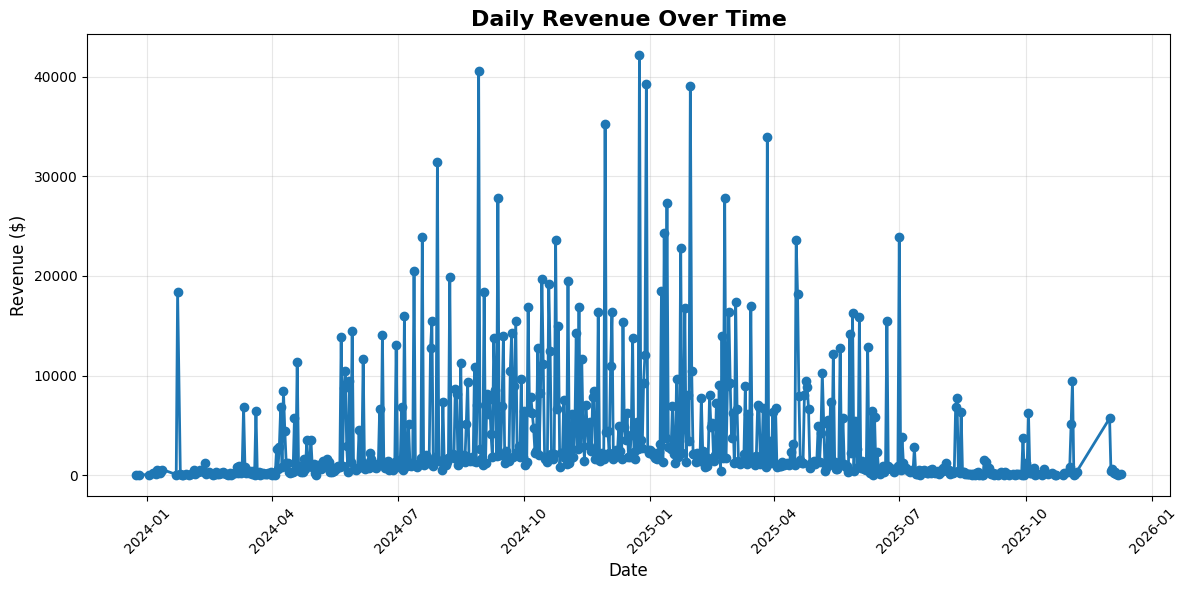

In [26]:
# Plot a simple line chart of daily revenue using matplotlib.
daily_revenue = orders_df.groupby('date')['paid_price'].sum().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_revenue.index, daily_revenue.values, marker='o', linestyle='-', linewidth=2)

plt.title('Daily Revenue Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('daily_revenue_DATA1.png', dpi=300, bbox_inches='tight')

plt.show()